In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
data = pd.read_csv('train.csv', encoding='windows-1255')

1. property_type

In [5]:
data['property_type'].value_counts()

דירה                                635
גג/פנטהאוז                           26
כללי                                 23
דירת גן                              23
גג/ פנטהאוז                          14
דופלקס                               12
סטודיו/לופט                          10
דירה להשכרה                          10
יחידת דיור                            9
מרתף/פרטר                             6
חניה                                  4
פרטי/קוטג'                            3
מחסן                                  2
גג/פנטהאוז להשכרה                     2
????????                              1
בית פרטי/ קוטג'                       1
החלפת דירות                           1
סאבלט                                 1
דו משפחתי                             1
באתר מופיע ערך שלא ברשימה הסגורה      1
דירת גן להשכרה                        1
Name: property_type, dtype: int64

In [ ]:
data[(data['property_type']=='Квартира')| (data['property_type'] == 'באתר מופיע ערך שלא ברשימה הסגורה')]
#נראה אם צריך לטפל בהם נקודתית לאחר ההשלמה מהתיאור

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
147,באתר מופיע ערך שלא ברשימה הסגורה,לב תל אביב החלק הדרומי,דרך מנחם בגין 19,1.0,3 מתוך 5,25,0.0,NaN,0.0,0.0,...,1,0,0,1,0,1,1,3500.0,11.0,4385.0
551,Квартира,יפו ג,יפת 203,2.0,3,24,16.0,0.0,12.0,1700.0,...,1,0,0,0,1,1,1,1700.0,6.0,7600.0


שלבי הטיפול:
1. השלמה באמצעות התיאור - מציאת מידע ומילוי/הכרעה אם כבר קיים ערך --אליאור
2. איחוד הערכים לקטגוריות שהגדרנו
3. מילוי "דירה" לערכים חסרים
4. הורדת שורות שהערך שלהן בעמודה לא נמצא ברשימה property_types - 
לוודא שלא הורדנו יותר מידי שורות 


In [17]:
#כאן צריך להיות הסידור מהתיאור, אלא אם נעשה במרוכז על הכל לפני

In [14]:
#פונקציה לייצור אחידות בערכים הקטגוריאליים של סוג הנכס + הורדת השורות שהן לא דירת מגורים
def update_property_type(data: pd.DataFrame):
    data['property_type'] = np.where(
        data['property_type'].str.contains(r'גג|פנטהאוז', case=False, na=False), 'גג/פנטהאוז', 
        np.where(
            data['property_type'].str.contains(r'גן|גינה', case=False, na=False), 'דירת גן',
            np.where(
                data['property_type'].str.contains(r'דופלקס|דו', case=False, na=False), 'דופלקס',
                np.where(
                    data['property_type'].str.contains(r'סטודיו', case=False, na=False), 'סטודיו/לופט',
                    np.where(
                        data['property_type'].str.contains(r'פרטי|קוטג\'|קוטג', case=False, na=False), 'פרטי/קוטג\'',
                        np.where(
                            data['property_type'].str.contains(r'מרתף|פרטר', case=False, na=False), 'מרתף/פרטר',
                            np.where(
                                data['property_type'].str.contains(r'יחידה|יחידת', case=False, na=False), 'יחידת דיור',
                                np.where(
                                    data['property_type'].str.contains(r'חניה', case=False, na=False), 'חניה',
                                    np.where(
                                        data['property_type'].str.contains(r'מחסן', case=False, na=False), 'מחסן',
                                        np.where(
                                            data['property_type'].str.contains(r'משרד', case=False, na=False), 'משרד',
                                            np.where(
                                                data['property_type'].str.contains(r'חנות|מסחר', case=False, na=False), 'חנות',
                                                np.where(
                                                    data['property_type'].str.contains(r'אחר', case=False, na=False), 'אחר',
                                                    'דירה'  # ברירת המחדל אם לא נמצא אף מילה
                                                )
                                            )
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )

    # סינון כך שישארו רק השורות של דירות מגורים
    property_types = ["דירה", "גג/פנטהאוז", "דירת גן", "דופלקס", "סטודיו/לופט", "פרטי/קוטג'", "מרתף/פרטר", "יחידת דיור"]
    data = data[data['property_type'].isin(property_types)]


2. Neighborhood

שלבי הטיפול:
1. הורדת שורות ללא שכונה (כי אז מדובר בפרסומות, הסינון שלנו היה אמור להיות לפי שכונה) והורדת שכונות שלא נמצות ברשימת השכונות של המטלה (כי אז מדובר במודעת דירה מפרסומת)
2. טיפול בשורות כפולות

In [20]:
#רשימת השכונות בתל אביב שהיו חלק מהמטלה (אחרת, מדובר בשכונות שנכנסו בפרסומות)
neighborhoods = [
    "הצפון הישן החלק המרכזי", "בית שטראוס",
    "לב תל אביב החלק הצפוני", "נוה ברבור",
    "הצפון החדש החלק הדרומי", "נוה אביבים",
    "הצפון הישן החלק הצפוני", "מע\"ר צפוני",
    "הצפון הישן החלק הדרום מזרחי", "רמת אביב ג",
    "פלורנטין", "עג'מי",
    "הקריה", "שבזי",
    "הצפון החדש סביבת ככר המדינה", "שיכון בבלי",
    "הצפון הישן החלק הדרום מערבי", "מונטיפיורי",
    "הגוש הגדול", "מרכז יפו מערבית לשדרות ירושלים",
    "קרית שלום", "נוה שרת",
    "לב תל אביב החלק הדרומי", "נוה חן",
    "כרם התימנים", "תל כביר",
    "שפירא", "ביצרון",
    "הצפון החדש החלק הצפוני", "נוה אליעזר",
    "צפון יפו", "נחלת יצחק",
    "נוה שאנן", "גבעת הרצל",
    "רמת אביב החדשה", "עזרא",
    "יד אליהו", "רביבים",
    "כוכב הצפון", "גני צהלה",
    "הדר יוסף", "לבנה",
    "חוף הצוק", "לינקולן",
    "פארק צמרת", "נאות אפקה א",
    "תוכנית ל",
    "צהלון", "המשתלה",
    "התקווה",
    "יפו ד", "תל חיים", "כפיר", "ניר אביב", "תל ברוך צפון",
    "מרכז יפו מזרחית לשדרות ירושלים",
    "רמת החייל",
    "נאות אפקה ב", "אזורי חן", "שיכוני חיסכון", "אפקה", "דקר", "רמת אביב", "יפו ג", "רמת ישראל", "רמת", "הטייסים", "נמל תל אביב", "צהלה"
]

In [23]:
def filter_neighborhoods(data, neighborhood_list):
    data = data[data['Neighborhood'].notna() & data['Neighborhood'].isin(neighborhoods)]

In [22]:
#לבדוק לגבי הורדת כפולים

3. Room Number

שלבי הטיפול:
1. גילינו שיש קבוצה שכל הדירות שלה עם מספר חדרים 0, לכן מילאנו את הקובץ באופן ידני לפי האתר וקראנו אותו לאחר המילוי
2. שינוי מספר החדרים לחדר 1 בכל דירות הסטודיו
3. השלמה מהתיאור
4. השלמת כל החסרים או 0, לפי שטח הדירה

לבדוק את ההמרה ל1 במספר חדרים, אולי זה ימיר יותר מידי והדירות הגבוליות האלה לרוב דירות 2 חדרים ולא סטודיו

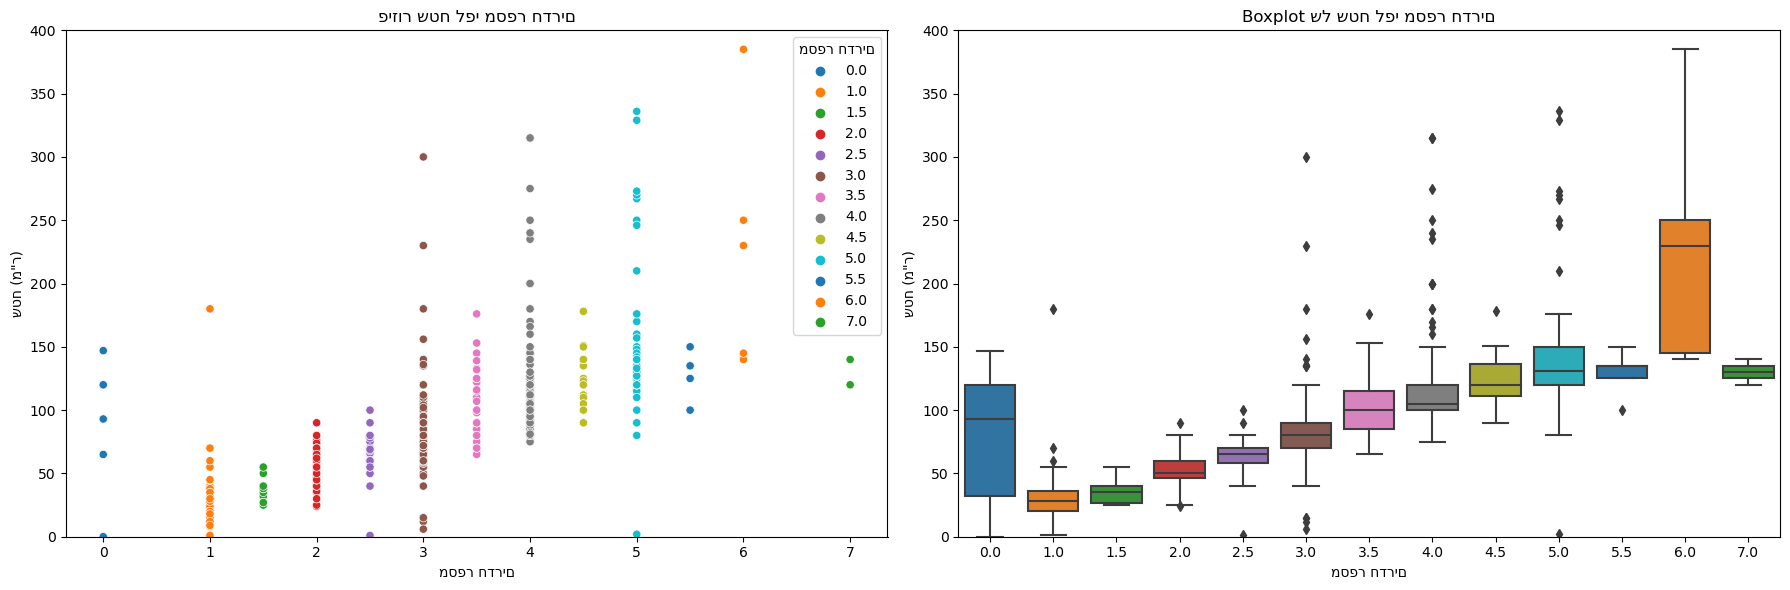

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# גרף פיזור
sns.scatterplot(
    data=data[data['area'].between(0, 400)],
    x='room_num',
    y='area',
    hue='room_num',
    palette='tab10',
    legend='full',
    ax=axes[0]
)
axes[0].set_xlabel('מספר חדרים')
axes[0].set_ylabel('שטח (מ"ר)')
axes[0].set_title('פיזור שטח לפי מספר חדרים')
axes[0].set_ylim(0, 400)
axes[0].legend(title='מספר חדרים')

# גרף בוקספלוט
sns.boxplot(
    data=data[data['area'].between(0, 400)],
    x='room_num',
    y='area',
    palette='tab10',
    ax=axes[1]
)
axes[1].set_xlabel('מספר חדרים')
axes[1].set_ylabel('שטח (מ"ר)')
axes[1].set_title('Boxplot של שטח לפי מספר חדרים')
axes[1].set_ylim(0, 400)

plt.tight_layout()
plt.show()

In [18]:
grouped = data.groupby('room_num')['area'].agg(
    mean='mean',
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75)
)
grouped

,mean,q1,q3
room_num,,,
0.0,77.857143,32.5,120.00
1.0,30.517857,20.0,35.75
1.5,36.000000,27.0,40.00
2.0,53.000000,46.0,60.00
2.5,76.444444,59.0,70.00
3.0,85.742358,70.0,90.00
3.5,101.076923,85.0,115.50
4.0,120.971751,100.0,120.00
4.5,124.200000,111.5,136.25


In [ ]:
#מילון שמתאים בין מספר חדרים לטווח של שטח הדירה
room_area = {
    1: (10, 30),
    1.5: (30, 40),
    2: (40, 60),
    2.5: (60, 70),
    3: (70, 90),
    3.5: (90, 105),
    4: (105, 115),
    4.5: (115, 125),
    5: (125, 145),
    5.5: (125, 150),
    6: (125, 150),
    7: (150, 500)
}

In [24]:
def fix_room_num(df):
    df.loc[df['property_type'] == 'סטודיו', 'room_num'] = 1

    mask = (df['room_num'].isna()) | (df['room_num'] == 0)
    for idx in df[mask].index:
        area = df.at[idx, 'area']
        if pd.notna(area):
            matched = False
            for room, (low, high) in room_area.items():
                if area >= low and area < high:
                    df.at[idx, 'room_num'] = room
                    matched = True
                    break
            if not matched:
                df.at[idx, 'room_num'] = 3  # אם לא נמצא טווח מתאים

In [23]:
#לעשות עוד בדיקה נוספת לפי עמודה אחרת (אם אין שטח) ולוודא איזה ערך אנחנו רוצים בסוף בדיפולט

4. Floor

שלבי הטיפול:
1. יש קבוצות שהשאירו את הערכים של הקומות בצורה של "מספר מתוך מספר" ולכן תיקנו את זה לפי הקוד שבו השתמשנו ביצירת הדאטה שלנו
2. יש קבוצה (כלומר שכונות מסוימות) שגילינו שכתבו בטעות במספר הקומה את שני המספרים יחד (קומה וקומות בקצף) ולכן הפונקציה מתקנת את זה
3. מילוי קומה מהתיאור
4. כל הדירות שמוגדרות דירות גן ואין להן 0 בערך הקומה - ישונו לסוג "דירה"
5. מילוי ערך חסר אם הוא לא תוקן עד כה
6. להפוך הכל לסוג int

In [37]:
#פונקציה לסידור הבעיה בהערה 1
def clean_floor_columns(df):
    # טיפול ב-"קרקע"
    mask_ground = df["floor"].astype(str).str.contains("קרקע", na=False)
    df.loc[mask_ground, "floor"] = (
        df.loc[mask_ground, "floor"]
        .astype(str)
        .str.replace("קרקע", "0", regex=False)
    )

    # טיפול בערכים עם " מתוך "
    mask = df["floor"].astype(str).str.contains(" מתוך ", na=False)

    # חילוץ total_floors
    df.loc[mask, "total_floors"] = (
        df.loc[mask, "floor"]
        .astype(str)
        .str.split(" מתוך ")
        .str[1]
        .astype(float)
    )

    # חילוץ floor
    df.loc[mask, "floor"] = (
        df.loc[mask, "floor"]
        .astype(str)
        .str.split(" מתוך ")
        .str[0]
        .astype(float)
    )

In [ ]:
#פונקציה לסידור הבעיה בהערה 2
def fix_floors_for_df(df):
    def fix_floors(row):
        tot = row['total_floors']
        flr = row['floor']
        flr_str = str(flr)
        tot_str = str(tot)
        
        if tot == 0:
            # Swap: set total_floors to the original floor value and floor to 0
            return pd.Series({'floor': 0, 'total_floors': flr})
        else:
            # If the floor value ends with total_floors digits, remove that part
            if flr_str.endswith(tot_str):
                new_floor_str = flr_str[:-len(tot_str)]
                new_floor = int(new_floor_str) if new_floor_str else 0
            else:
                new_floor = flr
            return pd.Series({'floor': new_floor, 'total_floors': tot})

    # מסכה לשורות שבהן floor גדול מ-total_floors
    mask = df['floor'] > df['total_floors']
    
    # החל על השורות האלו את הפונקציה
    df.loc[mask, ['floor', 'total_floors']] = df.loc[mask].apply(fix_floors, axis=1)

In [39]:
#4 טיפול בבעיה בהערה
def fix_garden_apartment_floor(df):
    # מסכה: דירות שהן דירת גן והקומה שלהן אינה 0
    mask = (df['property_type'] == 'דירת גן') & (df['floor'] != 0)
    
    # שינוי ערך סוג הנכס ל-"דירה"
    df.loc[mask, 'property_type'] = 'דירה'

5. Area

שלבי הטיפול:
1. הורדת דירות עם שטח נמוך מ15 (או טיפול בהן, תלוי בהצלחת המידע בתיאור)
2. טיפול בשטחים הגדולים מ350 לפי חציון השטח של מספר החדרים המתאים
- אם אנחנו מאמינים בהשלמה מהתיאור, עדיף שהתיקון הזה יקרה לפני ההשלמה כדי שלא ידרוס אותה

In [27]:
# טיפול בהערה 1
# #צריך להחליט אם להשתמש בפונק הזאת ולהוריד על הדרך מעט דירות אמיתיות, או לא להשתמש ולקחת סיכון שישארו שורות שהן לא דירות
def remove_small_area_rows(df):
    # ודא שהעמודה area היא מספרית
    df['area'] = pd.to_numeric(df['area'], errors='coerce')
    
    # מחק את השורות שבהן הערך בעמודה area קטן מ-15
    df.drop(df[df['area'] < 15].index, inplace=True)

In [28]:
#טיפול בהערה 2
def fix_large_area_with_median(df):
    # המרה לסוגים מספריים
    df['area'] = pd.to_numeric(df['area'], errors='coerce')
    df['room_num'] = pd.to_numeric(df['room_num'], errors='coerce')

    # יצירת מיפוי של חציון שטח לכל room_num (רק עבור area תקני)
    medians = df[df['area'] <= 350].groupby('room_num')['area'].median()

    # יצירת מסכה לשורות בעייתיות
    mask = df['area'] > 350

    # החלפה של הערכים ב-area לפי החציון המתאים
    df.loc[mask, 'area'] = df.loc[mask, 'room_num'].map(medians)


6. Garden Area

שלבי הטיפול:
1. השלמת כל הערכים החסרים ל-0. גילינו שמדובר באותן קבוצות שלא שינו ל-0 כאשר אין שטח גינה שמילאנו
- כרגע השארנו את דירות הגן עם שטח 0 כמו שהם. ננסה לבדוק את השינויים במודל עצמו (להוריד את העמודה או להכניס ממוצע/חציון)

In [34]:
def fill_missing_garden_area(df):
    # ודא שהעמודה garden_area היא מסוג float
    df['garden_area'] = pd.to_numeric(df['garden_area'], errors='coerce')
    
    # החלפת ערכים חסרים ב-0.0
    df['garden_area'].fillna(0.0, inplace=True)

7. Days to Enter

In [42]:
data[data["days_to_enter"].isnull()]

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
2,דירה,הצפון הישן החלק המרכזי,וורמיזה 5,2.5,1,65,NaN,NaN,12.0,400.0,...,1,1,0,0,1,0,1,9000.0,8.0,740.00
5,דירה,הצפון הישן החלק המרכזי,נחום סוקולוב 4,4.0,3,120,NaN,NaN,12.0,600.0,...,0,1,1,0,0,1,0,9000.0,10.0,1098.00
8,דירה,הצפון הישן החלק המרכזי,דיזנגוף,3.0,6,87,NaN,NaN,12.0,NaN,...,1,1,1,1,1,1,1,9500.0,13.0,0.00
9,דירה,הצפון הישן החלק המרכזי,אמסטרדם,3.0,3,100,NaN,NaN,12.0,475.0,...,1,1,0,0,1,0,0,9750.0,10.0,628.00
21,דירה,הצפון הישן החלק המרכזי,רחל 4,3.0,3,89,NaN,NaN,12.0,700.0,...,1,0,1,0,1,0,1,9900.0,8.0,245.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,דירה,הצפון החדש סביבת ככר המדינה,שרת משה 55,2.5,1,80,0.0,NaN,12.0,500.0,...,0,0,1,0,1,0,1,6000.0,11.0,2083.00
752,דירה,הצפון החדש סביבת ככר המדינה,אבן גבירול 99,2.5,2,80,0.0,NaN,12.0,450.0,...,0,0,1,0,0,0,1,5600.0,4.0,856.00
754,דירה,NaN,רמת פנקס 1,6.0,2,230,270.0,NaN,NaN,NaN,...,0,0,0,0,1,0,0,2419000.0,4.0,10542.00
755,דירה,NaN,קרן היסוד 322,3.0,1,72,0.0,NaN,NaN,NaN,...,0,0,1,0,0,0,1,1690000.0,7.0,15279.00


In [43]:
data[data["days_to_enter"]==0]

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
0,דירה,הצפון הישן החלק המרכזי,"מהר""ל 25",3.0,2,71,NaN,0.0,12.0,467.0,...,1,0,0,1,1,0,0,10150.0,6.0,1005.00
1,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 35,3.0,1,70,NaN,0.0,12.0,240.0,...,1,0,1,0,1,0,0,6600.0,3.0,253.00
3,דירה,הצפון הישן החלק המרכזי,עמנואל הרומי 30,2.0,3,40,NaN,0.0,12.0,100.0,...,0,0,0,0,0,0,0,5800.0,2.0,1206.00
4,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 50,3.0,1,70,NaN,0.0,11.0,250.0,...,1,0,1,0,0,0,1,7700.0,5.0,255.00
6,דירה,הצפון הישן החלק המרכזי,אהרון דוד גורדון 6,4.0,2,100,NaN,0.0,12.0,600.0,...,1,0,1,0,0,0,1,11000.0,1.0,1200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,גג/פנטהאוז,מונטיפיורי,יהודית 33,2.5,5,55,0.0,0.0,12.0,500.0,...,1,0,0,1,1,0,1,6300.0,3.0,1.69
784,דירה,הצפון הישן החלק הדרום מערבי,בן יהודה 88,3.0,2,90,0.0,0.0,12.0,500.0,...,1,0,0,0,0,1,1,15000.0,4.0,1.11
785,דירה,הצפון הישן החלק הדרום מערבי,רופין 22,2.0,3,80,0.0,0.0,12.0,450.0,...,1,0,0,0,1,0,1,8000.0,5.0,1.57
786,סטודיו/לופט,מונטיפיורי,שדרות יהודית 27,1.0,3,30,0.0,0.0,6.0,180.0,...,1,0,0,0,0,1,1,4000.0,0.0,3.21


.כ600 שורות עם ערך 0, ו180 שורות עם ערך חסר 
נראה שבכלל אין מה להכניס את העמודה הזאת

8. Num of Payments

In [44]:
data[data["num_of_payments"]==0]

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
147,דירה,לב תל אביב החלק הדרומי,דרך מנחם בגין 19,1.0,3 מתוך 5,25,0.0,NaN,0.0,0.0,...,1,0,0,1,0,1,1,3500.0,11.0,4385.0
371,דירה,NaN,NaN,0.0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,10000.0,8.0,0.0
372,דירה,NaN,NaN,0.0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,3799.0,5.0,0.0
373,גג/פנטהאוז,מערב,השר שפירא 14,0.0,44,120,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,1,3090000.0,12.0,14788.0
389,דירה,כוכב הצפון,NaN,5.0,17,120,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,3000.0,1.0,NaN


In [45]:
data[data["num_of_payments"].isnull()]

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
264,דירה,נחלת יצחק,NaN,3.0,20,300,0.0,NaN,NaN,NaN,...,1,0,0,0,1,1,0,NaN,2.0,NaN
494,דירה,נמל תל אביב,NaN,4.5,0,140,0.0,0.0,NaN,NaN,...,1,1,0,0,1,1,1,1980.0,1.0,1300.000
623,דירה,הצפון הישן החלק הדרום מזרחי,עין חרוד,3.5,4,90,0.0,NaN,NaN,NaN,...,1,0,0,0,0,0,0,5500.0,0.0,1.400
673,דירה,עג'מי,קדם,1.0,0,60,0.0,0.0,NaN,NaN,...,1,1,1,0,1,0,1,NaN,0.0,6.285
716,פרטי/קוטג',הקריה,הקריה,6.0,0,250,0.0,NaN,NaN,NaN,...,1,0,0,1,0,0,1,2100.0,8.0,1308.000
754,דירה,NaN,רמת פנקס 1,6.0,2,230,270.0,NaN,NaN,NaN,...,0,0,0,0,1,0,0,2419000.0,4.0,10542.000
755,דירה,NaN,קרן היסוד 322,3.0,1,72,0.0,NaN,NaN,NaN,...,0,0,1,0,0,0,1,1690000.0,7.0,15279.000


In [46]:
data[data["num_of_payments"]==12]

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
0,דירה,הצפון הישן החלק המרכזי,"מהר""ל 25",3.0,2,71,NaN,0.0,12.0,467.0,...,1,0,0,1,1,0,0,10150.0,6.0,1005.00
1,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 35,3.0,1,70,NaN,0.0,12.0,240.0,...,1,0,1,0,1,0,0,6600.0,3.0,253.00
2,דירה,הצפון הישן החלק המרכזי,וורמיזה 5,2.5,1,65,NaN,NaN,12.0,400.0,...,1,1,0,0,1,0,1,9000.0,8.0,740.00
3,דירה,הצפון הישן החלק המרכזי,עמנואל הרומי 30,2.0,3,40,NaN,0.0,12.0,100.0,...,0,0,0,0,0,0,0,5800.0,2.0,1206.00
5,דירה,הצפון הישן החלק המרכזי,נחום סוקולוב 4,4.0,3,120,NaN,NaN,12.0,600.0,...,0,1,1,0,0,1,0,9000.0,10.0,1098.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,דירה,מונטיפיורי,המסגר 80,1.0,4,9,0.0,0.0,12.0,333.0,...,0,0,0,0,0,0,0,1450.0,1.0,2.90
783,גג/פנטהאוז,מונטיפיורי,יהודית 33,2.5,5,55,0.0,0.0,12.0,500.0,...,1,0,0,1,1,0,1,6300.0,3.0,1.69
784,דירה,הצפון הישן החלק הדרום מערבי,בן יהודה 88,3.0,2,90,0.0,0.0,12.0,500.0,...,1,0,0,0,0,1,1,15000.0,4.0,1.11
785,דירה,הצפון הישן החלק הדרום מערבי,רופין 22,2.0,3,80,0.0,0.0,12.0,450.0,...,1,0,0,0,1,0,1,8000.0,5.0,1.57


גם כאן נראה שהעמודה לא רלוונטית

9. Monthly Arnona

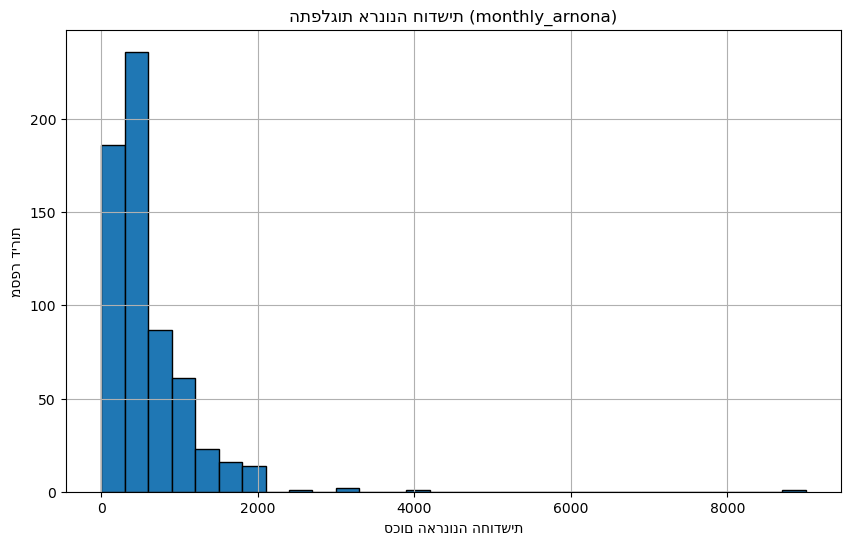

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(data['monthly_arnona'].dropna(), bins=30, edgecolor='black')

# כותרות
plt.title('התפלגות ארנונה חודשית (monthly_arnona)')
plt.xlabel('סכום הארנונה החודשית')
plt.ylabel('מספר דירות')
plt.grid(True)
plt.show()

In [56]:
data[data["monthly_arnona"]<100]

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
138,דירת גן,לב תל אביב החלק הדרומי,לבונטין 1111,2.0,קרקע מתוך קרקע,50,30.0,NaN,12.0,0.0,...,1,0,0,0,1,0,1,9000.0,13.0,3975.0
144,דירה,לב תל אביב החלק הדרומי,שדרות רוטשילד,4.0,6 מתוך 25,145,0.0,0.0,12.0,0.0,...,1,1,1,1,1,1,1,22000.0,12.0,3041.0
147,דירה,לב תל אביב החלק הדרומי,דרך מנחם בגין 19,1.0,3 מתוך 5,25,0.0,NaN,0.0,0.0,...,1,0,0,1,0,1,1,3500.0,11.0,4385.0
149,דירה,לב תל אביב החלק הדרומי,נחלת בנימין 42,7.0,1 מתוך 3,120,0.0,0.0,12.0,0.0,...,1,1,0,0,1,1,1,11000.0,13.0,3841.0
151,דירה,תל חיים,1080 1,2.5,קרקע מתוך קרקע,1,0.0,NaN,12.0,0.0,...,0,0,0,0,0,0,0,1.0,13.0,4925.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,דירה,הצפון הישן החלק הצפוני,יוחנן הורקנוס 12,2.0,0,90,0.0,0.0,12.0,0.0,...,0,0,0,0,0,0,0,12.0,0.0,3368.0
584,דירה,הצפון הישן החלק הצפוני,שדרות נורדאו 6,3.0,3,70,0.0,0.0,12.0,0.0,...,1,0,0,0,0,0,1,7500.0,9.0,3200.0
585,דירה,הצפון הישן החלק הצפוני,דיזנגוף 279,2.0,3,50,0.0,0.0,12.0,0.0,...,1,0,0,0,0,1,1,6500.0,9.0,2964.0
586,דירה,הצפון הישן החלק הצפוני,אוסישקין 33,2.0,3,53,0.0,0.0,12.0,0.0,...,1,0,1,0,1,0,1,8000.0,3.0,3994.0


In [64]:
data[data["monthly_arnona"].isnull()]

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
8,דירה,הצפון הישן החלק המרכזי,דיזנגוף,3.0,6,87,NaN,NaN,12.0,NaN,...,1,1,1,1,1,1,1,9500.0,13.0,0.00
15,דירה,הצפון הישן החלק המרכזי,דיזנגוף 168,3.0,4,70,NaN,0.0,12.0,NaN,...,1,0,0,1,1,0,1,7700.0,8.0,121.00
52,דירה,בית שטראוס,גרוזנברג 6,4.0,0,110,NaN,0.0,12.0,NaN,...,1,0,1,0,1,1,1,7500.0,9.0,3280.00
53,דירה,בית שטראוס,"שפ""ר",4.0,4,120,NaN,NaN,12.0,NaN,...,1,1,1,1,1,0,1,12000.0,10.0,3859.00
62,יחידת דיור,התקווה,השכל 7,2.0,0,40,4.0,NaN,9.0,NaN,...,0,0,0,0,1,0,0,3800.0,3.0,7514.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,חניה,הצפון הישן החלק הדרום מערבי,סירקין 11,1.0,1,1,1.0,0.0,4.0,NaN,...,0,0,0,0,1,0,0,750.0,2.0,1.46
765,דירה,הצפון הישן החלק הדרום מערבי,הירקון,3.0,1,102,0.0,0.0,12.0,NaN,...,1,1,1,1,1,0,1,11500.0,6.0,1.60
766,דירה,הצפון הישן החלק הדרום מערבי,פרישמן,3.0,10,230,0.0,0.0,12.0,NaN,...,1,1,0,1,1,1,1,38000.0,8.0,0.86
767,סטודיו/לופט,מונטיפיורי,רבניצקי 7,2.0,5,50,0.0,0.0,12.0,NaN,...,0,1,0,0,0,0,0,3000.0,2.0,2.92


In [60]:
correlation = data['area'].corr(data['monthly_arnona'])
correlation

0.2359862052044229

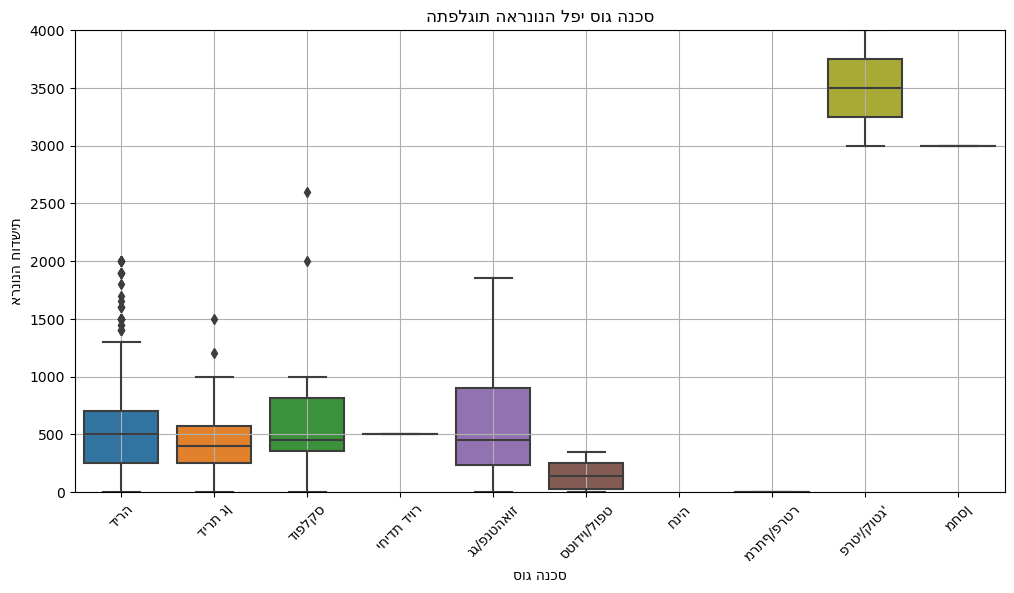

In [63]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='property_type', y='monthly_arnona', data=data)
plt.ylim(0, 4000)  # הגבלת ציר Y עד 4000
plt.xticks(rotation=45)
plt.title('התפלגות הארנונה לפי סוג הנכס')
plt.xlabel('סוג הנכס')
plt.ylabel('ארנונה חודשית')
plt.grid(True)
plt.show()

אולי לעשות איזה רגרסיה לפי סוג הנכס והשטח כדי להשלים את העכים החסרים בארנונה

צריך לבדוק אם זה סביר ולא אונס את הדאטה כיון שיש 160 ערכים חסרים + 108 אפסים

10. Building tax

In [66]:
data[data["building_tax"]==0]

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
71,דירה,הגוש הגדול,יחזקאל שטרייכמן 2,5.0,3,118,0.0,NaN,12.0,NaN,...,1,1,0,1,1,0,0,13000.0,6.0,4826.00
72,דירה,הגוש הגדול,אמיר גלבוע 9,3.0,6,80,0.0,NaN,12.0,NaN,...,1,1,0,1,1,1,0,10950.0,8.0,4761.00
74,דירה,הגוש הגדול,ארתור רובינשטיין 8,3.0,5,104,6.0,NaN,12.0,NaN,...,1,1,0,1,1,0,1,9500.0,10.0,4769.00
79,דירה,הגוש הגדול,ארתור רובינשטיין,5.0,9,250,0.0,0.0,12.0,NaN,...,1,1,0,1,1,0,1,25500.0,14.0,4724.00
80,דירה,הגוש הגדול,NaN,4.5,1,112,0.0,NaN,12.0,NaN,...,1,1,0,1,1,0,0,12500.0,2.0,4778.00
82,דירה,הגוש הגדול,NaN,5.0,5,149,0.0,NaN,12.0,NaN,...,1,1,0,1,1,0,1,17000.0,4.0,4778.00
83,דירה,הגוש הגדול,NaN,5.0,6,150,0.0,NaN,12.0,NaN,...,1,1,0,1,1,1,1,16000.0,9.0,4778.00
84,דירה,הגוש הגדול,אמיר גלבוע,5.0,4,140,0.0,0.0,12.0,NaN,...,1,1,0,1,1,1,1,14900.0,5.0,4680.00
85,דירה,הגוש הגדול,NaN,4.0,2,110,0.0,NaN,12.0,NaN,...,1,1,0,1,1,0,0,10400.0,1.0,4778.00
138,דירת גן,לב תל אביב החלק הדרומי,לבונטין 1111,2.0,קרקע מתוך קרקע,50,30.0,NaN,12.0,0.0,...,1,0,0,0,1,0,1,9000.0,13.0,3975.00


In [67]:
data[data["building_tax"].isnull()]

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
8,דירה,הצפון הישן החלק המרכזי,דיזנגוף,3.0,6,87,NaN,NaN,12.0,NaN,...,1,1,1,1,1,1,1,9500.0,13.0,0.0
50,דופלקס,בית שטראוס,מונטיפיורי 21,3.0,3,90,20.0,NaN,12.0,350.0,...,1,1,0,1,1,1,0,11000.0,4.0,3544.0
52,דירה,בית שטראוס,גרוזנברג 6,4.0,0,110,NaN,0.0,12.0,NaN,...,1,0,1,0,1,1,1,7500.0,9.0,3280.0
53,דירה,בית שטראוס,"שפ""ר",4.0,4,120,NaN,NaN,12.0,NaN,...,1,1,1,1,1,0,1,12000.0,10.0,3859.0
62,יחידת דיור,התקווה,השכל 7,2.0,0,40,4.0,NaN,9.0,NaN,...,0,0,0,0,1,0,0,3800.0,3.0,7514.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,דירה,הצפון החדש סביבת ככר המדינה,פייבל,5.0,3,127,0.0,0.0,12.0,500.0,...,0,0,0,1,1,0,1,11000.0,5.0,2245.0
733,דירה,הצפון החדש סביבת ככר המדינה,משה שרת,4.0,1,160,0.0,0.0,4.0,NaN,...,0,0,1,0,1,0,1,6000.0,14.0,2425.0
739,דירה,הצפון החדש סביבת ככר המדינה,הא באייר 56,4.0,2,90,0.0,0.0,12.0,NaN,...,0,0,0,1,0,0,1,6000.0,14.0,1891.0
754,דירה,NaN,רמת פנקס 1,6.0,2,230,270.0,NaN,NaN,NaN,...,0,0,0,0,1,0,0,2419000.0,4.0,10542.0


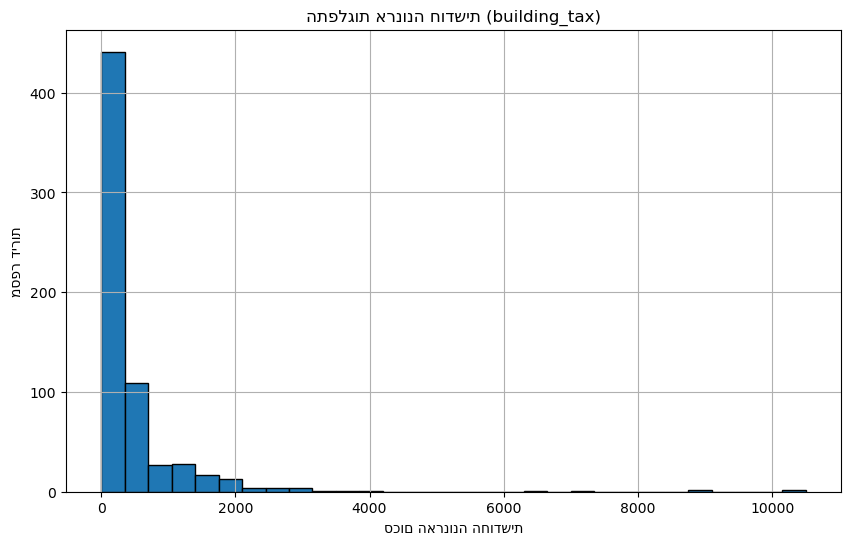

In [68]:
plt.figure(figsize=(10, 6))
plt.hist(data['building_tax'].dropna(), bins=30, edgecolor='black')

# כותרות
plt.title('התפלגות ארנונה חודשית (building_tax)')
plt.xlabel('סכום הארנונה החודשית')
plt.ylabel('מספר דירות')
plt.grid(True)
plt.show()